In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_medidas = pd.read_excel('./dados/BD_Disjuntores.xlsx', sheet_name='Documentos de Medida')

# Análise a Partir de Equipamento

A ideia da análise é encontrar valores determinados para os equipamentos em questão com base em seus pontos de medição, e, ainda, em seus documentos de medição. Para isso será necessário:

1. Definir uma classificação base para cada documento de medição.
2. Classificar os pontos de medição com base nos documentos de medição.
3. Classificar os equipamentos com base nos pontos de medição. 

## Definir classificação para cada ponto de medição

In [3]:
str((df_medidas['Cód.valorização'].isna().mean() * 100).round(2)) + '%'

'90.39%'

A maior parte dos pontos de medição (90%) não possuem de forma explícita a classificação, será necessário realizar um scrapping nas outras colunas de dados para encontrar a classificação real de cada um dos termos.

### Código de Valorização

Código de valorização é a coluna que contém os valores para a classificação do documento de medição. Será transcrita diretamente para a coluna 'Classifica', de modo que não perdemos os dados originais.

In [4]:
df_medidas['Classifica'] = df_medidas['Cód.valorização'].round(1).astype(str)
df_medidas['Classifica'].value_counts()

Classifica
nan    129262
2.0     12490
1.0       762
4.0       439
3.0        44
5.0         2
Name: count, dtype: int64

### Texto

O campo texto é o mais genérico da tabela, sem ter uma função específica, serviria como anotação da classificação do documento de medição para análise futura. Teoria essa mais fundada pela forte presença de 5, 3 e 2 na tabela.

In [5]:
df_medidas['Texto'].value_counts()

Texto
5                                           69746
3                                            9960
2                                            5123
Saneamento Contadores                        1672
/TEMPO FORA DO INTERVALO DE OPERAÇÃO:FEC      902
                                            ...  
acumulados agosto /2019                         1
acumulado mês dezembro 2019                     1
Acumulados mês outubro 2020                     1
PONTO QUENTE. RES ISOL ABERT CAM1: ENTRE        1
Leitura Dezembro/18                             1
Name: count, Length: 1029, dtype: int64

In [6]:
categorias = ['0', '1', '2', '3', '4', '5']

filtro = (df_medidas['Texto'].isin(categorias)) 
lenA = filtro.sum()

filtro = filtro & (df_medidas['Classifica'] == 'nan')
lenB = filtro.sum()

df_medidas.loc[filtro, 'Classifica'] = df_medidas.loc[filtro, 'Texto']

del filtro
del categorias

In [7]:
print(f"Precisão {(lenB/lenA):.3f}")
del lenA
del lenB

Precisão 0.875


In [8]:
df_medidas['Classifica'].value_counts()

Classifica
5      59663
nan    54451
2.0    12490
3       9422
2       5123
1.0      762
1        603
4.0      439
3.0       44
5.0        2
Name: count, dtype: int64

Como vemos, o conflito da coluna é baixo (0.875) com aquilo que já existe na tabela (Código de Valorização). Valorizando a ideia de que a coluna também era usada para armazenamento de classificações. Vale pontuar que o uso da segunda coluna reduz o buraco na cobertura em 67.9%

### Valor Teórico

Coluna que contém o valor teórico esperado para determinada medição. Por mais que não seja a tabela com os valores previstos para a classificação, a grande presença de '1.0' e de '5.0' me leva a crer no uso secundário dessa coluna para armazenamento de valores.

In [9]:
df_medidas['Valor teórico'].value_counts()

Valor teórico
540.0      11112
35.0        7372
1.0         4787
5.0         3770
20000.0     3655
           ...  
4.7            2
225.0          1
27.5           1
101.0          1
4.0            1
Name: count, Length: 210, dtype: int64

In [10]:
categorias = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0']

filtro = df_medidas['Valor teórico'].astype(str).isin(categorias)
lenA = filtro.sum()

filtro = filtro & (df_medidas['Classifica'] == 'nan')
lenB = filtro.sum()

df_medidas.loc[filtro, 'Classifica'] = df_medidas.loc[filtro, 'Valor teórico']

del filtro
del categorias

In [11]:
print(f"Precisão {(lenB/lenA):.4f}")
del lenA
del lenB

Precisão 0.6352


In [12]:
df_medidas['Classifica'].value_counts()

Classifica
5      59663
nan    48140
2.0    12490
3       9422
2       5123
1.0     4787
0.0     1325
1.0      762
1        603
4.0      439
5.0      198
3.0       44
5.0        2
4.0        1
Name: count, dtype: int64

Como vemos, o conflito da coluna é baixissimo (0.996) com aquilo que já existia na tabela (Código de Valorização), sendo moderado (0.635) quando comparado ao 'Texto'. Isso leva a crer que a coluna poderia também ser usada para armazenamento de classificações. Vale elencar que com a adição da 3a coluna, o buraco na cobertura é reduzido em 11,5%

In [13]:
### Ideia de análise para valores 'duplicados'
# filtroAux = filtro & ((df_medidas['Classifica'] == 'nan') | ((df_medidas['Classifica'] == df_medidas['Valor teórico'])))

### Homogenização da coluna classifica

In [35]:
df_medidas['Classifica'] = df_medidas['Classifica'].replace(['nan', 'NaN'], np.nan)
df_medidas['Classifica'] = df_medidas['Classifica'].astype(float)
# df_medidas['Classifica'] = df_medidas['Classifica'].map(lambda x: f"{x:.0f}" if pd.notnull(x) else np.nan)

In [15]:
df_medidas['Classifica'].value_counts()

Classifica
5    59863
2    17613
3     9466
1     6152
0     1325
4      440
Name: count, dtype: int64

In [16]:
str((df_medidas['Classifica'].isna().mean() * 100).round(2)) + '%'

'33.66%'

Como resultado do uso de colunas auxiliares para maximização da presença de classificação nas linhas da tabela, chegando a uma cobertura de 75% da tabela. Vale ressaltar que a metodologia utiliza de métodos que diminuem a qualidade do resultado esperado.

## Visualização de Resultados

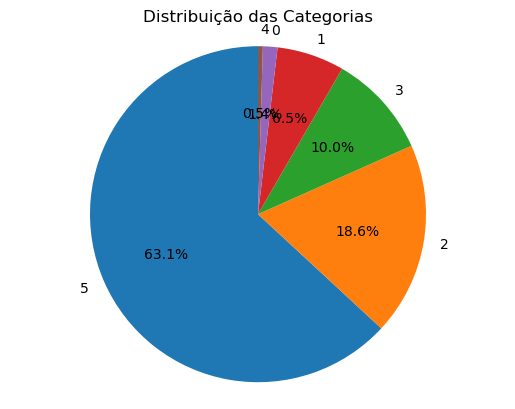

In [17]:
contagem = df_medidas['Classifica'].value_counts()

# Plot do gráfico de pizza
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição das Categorias')
plt.axis('equal')
plt.show()

In [36]:
df_filtrado = df_medidas[df_medidas['Classifica'].notnull()]
doc_mais_frequente = df_filtrado['Ponto medição'].value_counts().idxmax()
df_doc = df_filtrado[df_filtrado['Ponto medição'] == doc_mais_frequente]
df_doc = df_doc.sort_values('Data')

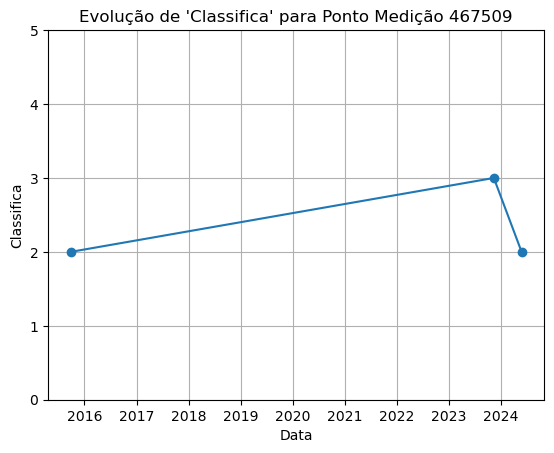

In [38]:
plt.plot(df_doc['Data'], df_doc['Classifica'], marker='o', linestyle='-')
plt.title(f"Evolução de 'Classifica' para Ponto Medição {doc_mais_frequente}")
plt.xlabel("Data")
plt.ylabel("Classifica")
plt.yticks(range(6))
plt.grid(True)
plt.show()

In [42]:
equipamento_mais_pontos = (
  df_filtrado.groupby('Equipamento')['Ponto medição']
  .nunique()
  .idxmax()
)
df_eqp = df_filtrado[df_filtrado['Equipamento'] == equipamento_mais_pontos]
df_eqp = df_eqp.sort_values('Data')

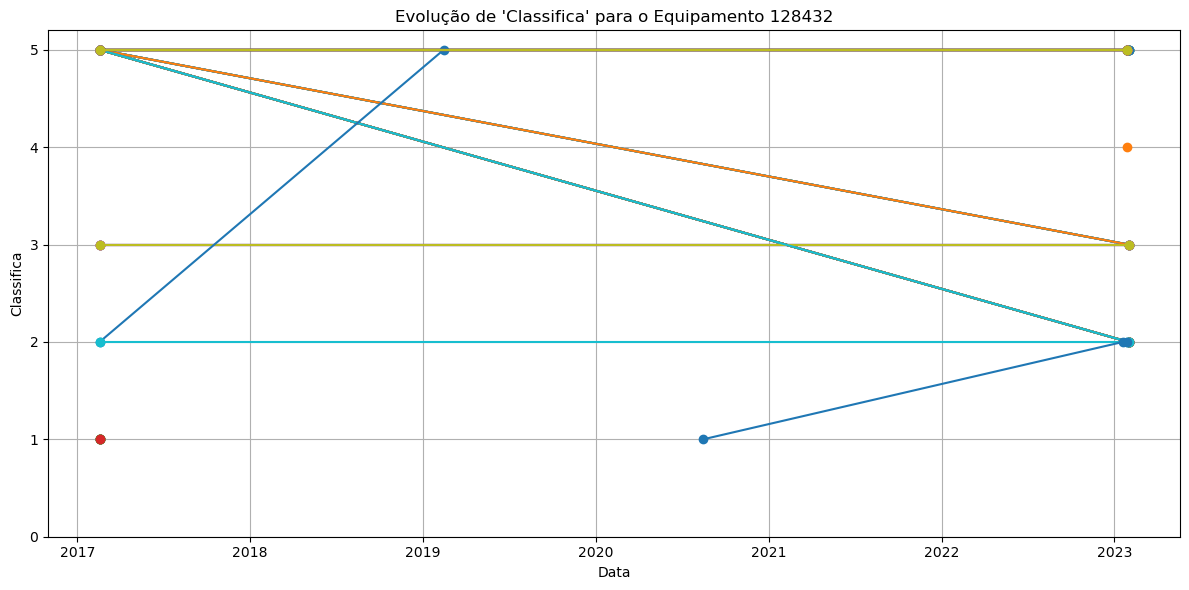

In [44]:
# Plotar uma linha para cada ponto de medição
plt.figure(figsize=(12, 6))
for ponto, grupo in df_eqp.groupby('Ponto medição'):
  plt.plot(grupo['Data'], grupo['Classifica'], marker='o', linestyle='-', label=f'{ponto}')

plt.title(f"Evolução de 'Classifica' para o Equipamento {equipamento_mais_pontos}")
plt.xlabel("Data")
plt.ylabel("Classifica")
plt.yticks(range(6))
plt.grid(True)
# plt.legend(title='Ponto Medição', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Busca por chaves duplicatas (nada feito)

### Mais de um ponto por documento

In [20]:
duplic = df_medidas.groupby('Doc.medição')['Ponto medição'].nunique().reset_index()
duplic[duplic['Ponto medição'] > 1]

,Doc.medição,Ponto medição


### Mais de um equipamento por ponto

In [21]:
duplic = df_medidas.groupby('Ponto medição')['Equipamento'].nunique().reset_index()
duplic = duplic[duplic['Equipamento'] > 1]
duplic

,Ponto medição,Equipamento
38228,467492,2


In [22]:
df_medidas[df_medidas['Ponto medição'].isin(duplic['Ponto medição'])]

,Equipamento,Ponto medição,Doc.medição,Data,Valor teórico,LimInfIntMed.,LimSupIntMed.,ValMed/PosTCont,Unid.caracter.,Cód.valorização,Txt.code codif.,Denominação,Texto,Classifica
17,127874,467492,5985385,2023-11-14,1.0,0.0,1.0,0.26,%,NaN,NaN,Fator de Potencia Bucha B2 Fase A,NaN,1
18,467509,467492,732683,2015-09-27,1.0,0.0,1.0,0.29,%,NaN,NaN,Fator de Potencia Bucha B2 Fase A,Ensaio realizado 12/05/2009,1
19,127874,467492,737867,2009-05-12,1.0,0.0,1.0,0.29,%,NaN,NaN,Fator de Potencia Bucha B2 Fase A,NaN,1
